# Week 1 Lab – Linear Regression with multiple features Part 2

**Objective:** Capture nonlinear and interaction effects using polynomial feature engineering and an explicit bias term:

L_hat = X @ w + b.

Where **@** is a operator for Matrix multiplication

**Feature Map:**

Construct the design matrix using the following features (do not include a constant column of ones):

X = [M, T, M^2, M*T]

## 0.1 Setup

In [1]:
%pip install numpy pandas matplotlib

  Using cached pandas-3.0.0-cp314-cp314-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (79 kB)
Using cached pandas-3.0.0-cp314-cp314-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl (10.9 MB)
Note: you may need to restart the kernel to use updated packages.


In [70]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)

## 1. Dataset visualization

Like in the previous notebook we are gonna use a given dataset which represents:

In [3]:
M = np.array([0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4])

L = np.array([0.15, 0.35, 1.00, 2.30, 4.10, 7.00, 11.2, 17.5, 25.0, 35.0])

T = np.array([3800, 4400, 5800, 6400, 6900, 7400, 7900, 8300, 8800, 9200])

## 1.1 L vs M and encode T

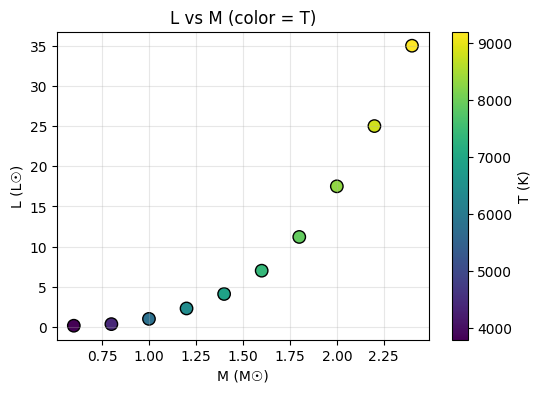

In [10]:
plt.figure(figsize=(6,4))
sc = plt.scatter(M, L, c=T, cmap="viridis", s=80, edgecolors="k")
plt.colorbar(sc, label="T (K)")
plt.xlabel("M (M☉)")
plt.ylabel("L (L☉)")
plt.title("L vs M (color = T)")
plt.grid(True, alpha=0.3)
plt.show()

## 2. Feature Engineering

Build X with numpy vectorization

In [9]:
# Number of Examples
n = M.shape[0]

M_2 = M ** 2
M_T = M * T 

X = np.column_stack([M, T, M_2, M_T ]) # Design Matrix

print("X (first 5 rows):\n", X[:5])
print("L (first 5):\n", L[:5])

X (first 5 rows):
 [[   0.6  3800.      0.36 2280.  ]
 [   0.8  4400.      0.64 3520.  ]
 [   1.   5800.      1.   5800.  ]
 [   1.2  6400.      1.44 7680.  ]
 [   1.4  6900.      1.96 9660.  ]]
L (first 5):
 [0.15 0.35 1.   2.3  4.1 ]


## 3. Loss and gradients (vectorized)

Implement ME (Cost Function) and gradients w.r.t. both w and b.

Hypothesis function is defined by $f_{w,b}(x)$

For a dataset with matrix $X$ and parameters $w$ and $b$, the vector of predictions is:
$$
\hat{L} = X w + b.
$$

In [17]:
def predict(X, w, b):
    return X @ w + b

## 3.1 Cost Function $J(w,b)$ (Vectorized)

We recall
$$
J(w,b) = \frac{1}{2m} \sum_{i=1}^{m} \big( f_{w,b}(x^{(i)}) - y^{(i)} \big)^2.
$$

In vector form, if we define the error vector $e = \hat{y} - y$, then
$$
J(w,b) = \frac{1}{2m} e^T e.
$$


In [18]:
def compute_cost(X, L, w, b):

    m_n = X.shape[0]
    L_hat = predict(X, w, b)
    error = L_hat - L
    cost = (error @ error) / (2 * m_n)
    return cost

# with w = 0 and b = 0
n = X.shape[1]
w_test = np.zeros(n)
b_test = 0.0
print("Cost with w=0, b=0:", compute_cost(X, L, w_test, b_test))


print(n)

Cost with w=0, b=0: 117.69675
4


## 3.2 Gradient of the Cost Function (Vectorized)

We derived:
$$
\nabla_w J(w,b) = \frac{1}{m} X^T (\hat{y} - y), \qquad
\frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^{m} (\hat{y}^{(i)} - y^{(i)}).
$$

We now implement this directly in NumPy.

In [19]:
def compute_gradient(X, L, w, b):
    m = X.shape[0]
    L_hat = predict(X, w, b)
    error = L_hat - L

    dj_dw = (X.T @ error) / m
    dj_db = np.sum(error) / m 

    return dj_dw, dj_db

dj_dw_test, dj_db_test = compute_gradient(X, L, w_test, b_test)
print("Gradient at w=0, b=0:")
print("dj_dw:", dj_dw_test)
print("dj_db", dj_db_test)

Gradient at w=0, b=0:
dj_dw: [    -21.523   -87845.         -45.9434 -185408.8   ]
dj_db -10.36


## 4. Gradient descent + convergence:

Train and plot loss vs iterations.

## 4.1 Gradient Descent for Multiple Features

We now put everything together into a gradient descent loop.

At each iteration:

1. Compute $\hat{y} = f_{w,b}(X)$.
2. Compute the gradients $\nabla_w J$ and $\partial J / \partial b$.
3. Update
   $$
   w := w - \alpha \nabla_w J, \qquad
   b := b - \alpha \frac{\partial J}{\partial b}.
   $$

In [36]:
def gradient_descent(X, L, w_init, b_init, alpha, num_iterations):
    w = w_init.copy()
    b = b_init
    history_it = []
    history_cost = []

    for i in range(num_iterations):
        dj_dw, dj_db = compute_gradient(X, L, w, b)
        w = w - alpha * dj_dw 
        b = b - alpha * dj_db 

        if i % 10 == 0 or i == num_iterations - 1:
            cost = compute_cost(X, L, w, b)
            history_it.append(i)
            history_cost.append(cost)
            print(f"Iteration {i:4d}: cost = {cost:8.4f}")
    
    return w, b, history_it, history_cost

alpha = 1e-9
num_iterations = 2000
w_init = np.zeros(n)
b_init = 0.0

w_learned, b_learned, it_hist, cost_hist = gradient_descent(X, L, w_init, b_init, alpha, num_iterations)
print("\nLearned parameters:")
print("w =", w_learned)
print("b =", b_learned)

Iteration    0: cost =  80.1334
Iteration   10: cost =  19.7645
Iteration   20: cost =  18.3887
Iteration   30: cost =  17.5240
Iteration   40: cost =  16.7139
Iteration   50: cost =  15.9520
Iteration   60: cost =  15.2354
Iteration   70: cost =  14.5613
Iteration   80: cost =  13.9273
Iteration   90: cost =  13.3310
Iteration  100: cost =  12.7700
Iteration  110: cost =  12.2424
Iteration  120: cost =  11.7462
Iteration  130: cost =  11.2794
Iteration  140: cost =  10.8403
Iteration  150: cost =  10.4274
Iteration  160: cost =  10.0389
Iteration  170: cost =   9.6736
Iteration  180: cost =   9.3299
Iteration  190: cost =   9.0067
Iteration  200: cost =   8.7026
Iteration  210: cost =   8.4166
Iteration  220: cost =   8.1476
Iteration  230: cost =   7.8946
Iteration  240: cost =   7.6567
Iteration  250: cost =   7.4328
Iteration  260: cost =   7.2223
Iteration  270: cost =   7.0242
Iteration  280: cost =   6.8380
Iteration  290: cost =   6.6627
Iteration  300: cost =   6.4979
Iteratio

## 4.2 Plot Cost over iterations

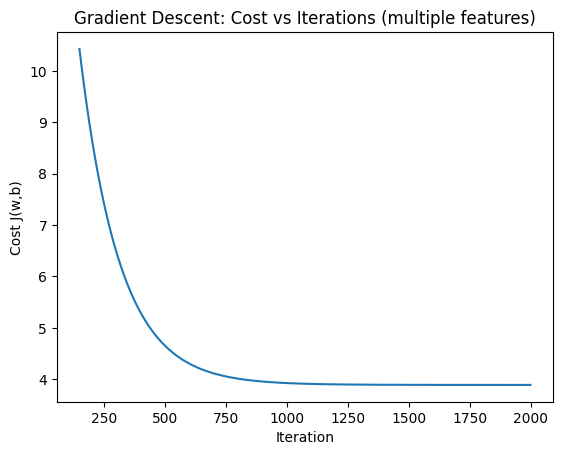

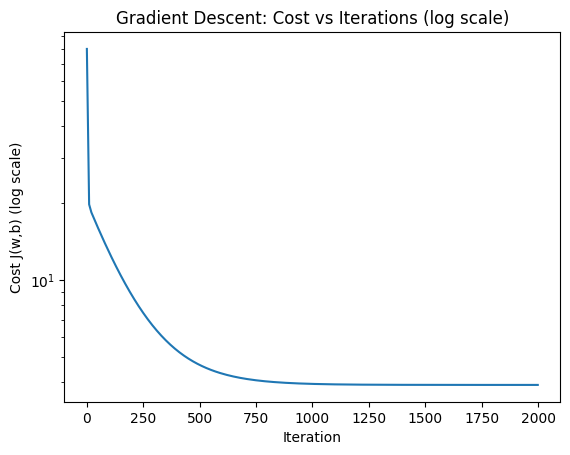

In [37]:
plt.figure()
plt.plot(it_hist[15:], cost_hist[15:])
plt.xlabel("Iteration")
plt.ylabel("Cost J(w,b)")
plt.title("Gradient Descent: Cost vs Iterations (multiple features)")
plt.show()

plt.figure()
plt.semilogy(it_hist, cost_hist)
plt.xlabel("Iteration")
plt.ylabel("Cost J(w,b) (log scale)")
plt.title("Gradient Descent: Cost vs Iterations (log scale)")
plt.show()

## 5. Feature Selection Experiment (Mandatory)

Compare: 

### **M1:** X = [M, T]

In [57]:
M1 = np.column_stack([M, T])
alpha = 1e-9
num_iterations = 1000
w_init = np.zeros(M1.shape[1])
b_init = 0.0

w_m1, b_m1, it_hist_m1, cost_hist_m1 = gradient_descent(M1, L, w_init, b_init, alpha, num_iterations)
print("\nLearned parameters (M1):")
print("w =", w_m1)
print("b =", b_m1)

cost_m1 = compute_cost(M1, L, w_m1, b_m1)
print("Total Loss (M1): ", cost_m1)

Iteration    0: cost = 110.1745
Iteration   10: cost =  65.6884
Iteration   20: cost =  49.8795
Iteration   30: cost =  44.2615
Iteration   40: cost =  42.2651
Iteration   50: cost =  41.5556
Iteration   60: cost =  41.3035
Iteration   70: cost =  41.2139
Iteration   80: cost =  41.1821
Iteration   90: cost =  41.1708
Iteration  100: cost =  41.1667
Iteration  110: cost =  41.1653
Iteration  120: cost =  41.1648
Iteration  130: cost =  41.1646
Iteration  140: cost =  41.1646
Iteration  150: cost =  41.1645
Iteration  160: cost =  41.1645
Iteration  170: cost =  41.1645
Iteration  180: cost =  41.1645
Iteration  190: cost =  41.1645
Iteration  200: cost =  41.1645
Iteration  210: cost =  41.1645
Iteration  220: cost =  41.1645
Iteration  230: cost =  41.1645
Iteration  240: cost =  41.1645
Iteration  250: cost =  41.1645
Iteration  260: cost =  41.1645
Iteration  270: cost =  41.1645
Iteration  280: cost =  41.1645
Iteration  290: cost =  41.1645
Iteration  300: cost =  41.1645
Iteratio

## Compare Predicted vs Actual (M1)

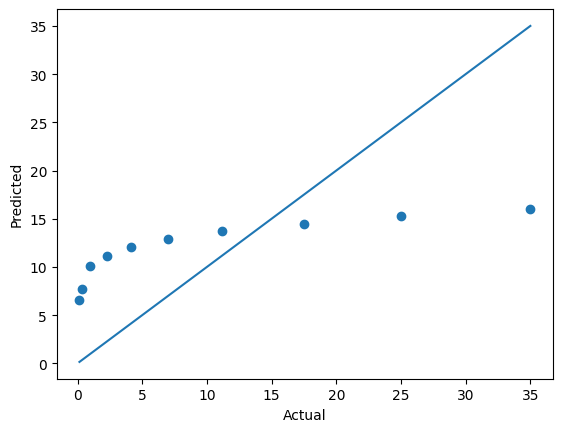

In [58]:
L_pred = predict(M1, w_m1, b_m1)

plt.figure()
plt.scatter(L, L_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.plot([L.min(), L.max()], [L.min(), L.max()])
plt.show()

### **M2:** X = [M, T, M^2]

In [59]:
M2 = np.column_stack([M, T, M_2])
alpha = 1e-9
num_iterations = 1000
w_init = np.zeros(M2.shape[1])
b_init = 0.0

w_m2, b_m2, it_hist_m2, cost_hist_m2 = gradient_descent(M2, L, w_init, b_init, alpha, num_iterations)
print("\nLearned parameters (M2):")
print("w =", w_m2)
print("b =", b_m2)

cost_m2 = compute_cost(M2, L, w_m2, b_m2)
print("Total Loss (M2): ", cost_m2)

Iteration    0: cost = 110.1745
Iteration   10: cost =  65.6884
Iteration   20: cost =  49.8795
Iteration   30: cost =  44.2615
Iteration   40: cost =  42.2651
Iteration   50: cost =  41.5556
Iteration   60: cost =  41.3035
Iteration   70: cost =  41.2139
Iteration   80: cost =  41.1821
Iteration   90: cost =  41.1707
Iteration  100: cost =  41.1667
Iteration  110: cost =  41.1653
Iteration  120: cost =  41.1648
Iteration  130: cost =  41.1646
Iteration  140: cost =  41.1645
Iteration  150: cost =  41.1645
Iteration  160: cost =  41.1645
Iteration  170: cost =  41.1645
Iteration  180: cost =  41.1645
Iteration  190: cost =  41.1645
Iteration  200: cost =  41.1645
Iteration  210: cost =  41.1645
Iteration  220: cost =  41.1645
Iteration  230: cost =  41.1645
Iteration  240: cost =  41.1645
Iteration  250: cost =  41.1645
Iteration  260: cost =  41.1645
Iteration  270: cost =  41.1645
Iteration  280: cost =  41.1645
Iteration  290: cost =  41.1645
Iteration  300: cost =  41.1645
Iteratio

## Compare Predicted vs Actual (M2)

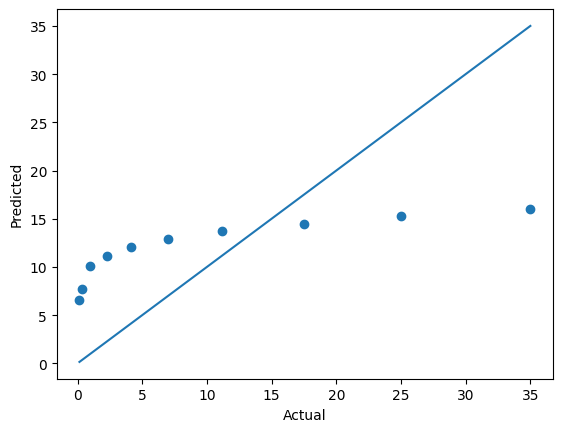

In [60]:
L_pred = predict(M2, w_m2, b_m2)

plt.figure()
plt.scatter(L, L_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.plot([L.min(), L.max()], [L.min(), L.max()])
plt.show()

### **M3:** X = [M, T, M^2, M*T]

In [ ]:
M3 = np.column_stack([M, T, M_2, M_T])
alpha = 1e-9
num_iterations = 1000
w_init = np.zeros(M3.shape[1])
b_init = 0.0

w_m3, b_m3, it_hist_m3, cost_hist_m3 = gradient_descent(M3, L, w_init, b_init, alpha, num_iterations)
print("\nLearned parameters (M3):")
print("w =", w_m3)
print("b =", b_m3)

cost_m3 = compute_cost(M3, L, w_m3, b_m3)
print("Total Loss (M3): ", cost_m3)

4
Iteration    0: cost =  80.1334
Iteration   10: cost =  19.7645
Iteration   20: cost =  18.3887
Iteration   30: cost =  17.5240
Iteration   40: cost =  16.7139
Iteration   50: cost =  15.9520
Iteration   60: cost =  15.2354
Iteration   70: cost =  14.5613
Iteration   80: cost =  13.9273
Iteration   90: cost =  13.3310
Iteration  100: cost =  12.7700
Iteration  110: cost =  12.2424
Iteration  120: cost =  11.7462
Iteration  130: cost =  11.2794
Iteration  140: cost =  10.8403
Iteration  150: cost =  10.4274
Iteration  160: cost =  10.0389
Iteration  170: cost =   9.6736
Iteration  180: cost =   9.3299
Iteration  190: cost =   9.0067
Iteration  200: cost =   8.7026
Iteration  210: cost =   8.4166
Iteration  220: cost =   8.1476
Iteration  230: cost =   7.8946
Iteration  240: cost =   7.6567
Iteration  250: cost =   7.4328
Iteration  260: cost =   7.2223
Iteration  270: cost =   7.0242
Iteration  280: cost =   6.8380
Iteration  290: cost =   6.6627
Iteration  300: cost =   6.4979
Iterat

## Compare Predicted vs Actual (M3)

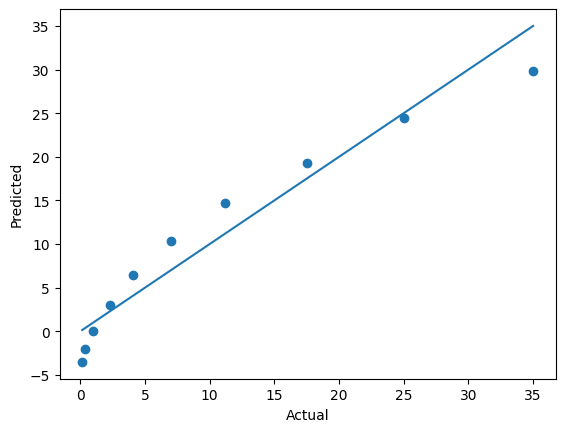

In [62]:
L_pred = predict(M3, w_m3, b_m3)

plt.figure()
plt.scatter(L, L_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.plot([L.min(), L.max()], [L.min(), L.max()])
plt.show()

## 6. Cost vs Interaction (mandatory)

for the full model (M3), vary the interaction coefficient w_MT across a reasonable range while keeping the other parameters fixed (e.g., at their trained values). Plot cost vs w_MT and explain what it indicates about interaction importance.

[-0.     -0.0023  0.      0.0023]


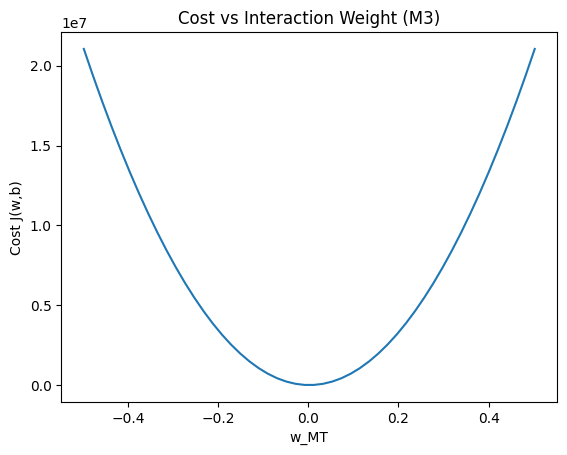

In [ ]:
m = M3.shape[0]
base = w_m3[3]
w_mt_vals = np.linspace(base - 0.5, base + 0.5, 50)

W = np.tile(w_m3, (w_mt_vals.size, 1))
W[:, 3] = w_mt_vals

preds = M3 @ W.T + b_m3
errors = preds - L.reshape(-1,1)
costs = np.sum(errors ** 2, axis=0) / (2 * m)

plt.figure()
plt.plot(w_mt_vals, costs)
plt.xlabel("w_MT")
plt.ylabel("Cost J(w,b)")
plt.title("Cost vs Interaction Weight (M3)")
plt.show()

### Conclusion about the interaction coefficient

By varying only the interaction coefficient **w_MT** and keeping the other parameters constant, we observe in the graphic how the cost changes.

We can observe the minimum, if it is flat, the interaction contributes little, in this case we can see is steep so interaction is significant.

## 7. Inference demo (mandatory)

predict luminosity for a new star (e.g., M=1.3, T=6600). Comment on reasonableness.

To predict the luminosity of this new star we will use M1 where we will define the new values, to build the design matrix but using the w_learned_m3 and b_learned_m3 values ​​that we obtained previously.

In [64]:
M_newStar = np.array([1.3])
T_newStar = np.array([6600])
M_2_newStar = M_newStar ** 2
M_T_newStar = M_newStar * T_newStar

X_newStar = np.column_stack([M_newStar, T_newStar, M_2_newStar, M_T_newStar])

print("The luminosity of the new star is: ", predict(X_newStar, w_m3, b_m3))



The luminosity of the new star is:  [4.6021]


Taking into account the given data, where the mass is greater than that of the Sun and the temperature is also hotter, obtaining a luminosity of this type (4.6021) is acceptable, classifying the star as type F.